# Sign language recognition

# Importing Libraries

In [ ]:
from IPython.display import clear_output
!pip install fasttext
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
clear_output()

In [ ]:
! mkdir dataset
! unzip {"/content/drive/MyDrive/for_colab/Assignment03.zip"} -d dataset
clear_output()

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import torch
import fasttext
import fasttext.util
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import random

## Read and Prepare the Dataset (10 points)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(root=os.path.join('dataset/Assignment03', 'train'), transform=transform)
test_dataset = ImageFolder(root=os.path.join('dataset/Assignment03', 'test'), transform=transform)

total_size = len(train_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, test_size] )

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size =batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
batch = next(iter(train_loader))
print(batch[0].shape)
print(batch[1].shape)
print(batch[1])

torch.Size([16, 3, 224, 224])
torch.Size([16])
tensor([1, 2, 2, 3, 5, 9, 2, 9, 2, 1, 5, 5, 6, 6, 5, 5])


## word embeddings (15 points)

In [ ]:
# fasttext.util.download_model('ar', if_exists='ignore')  # 'ar' is the language code for Arabic
ft = fasttext.load_model('/content/drive/MyDrive/for_colab/FT/cc.ar.300.bin')
ft = fasttext.util.reduce_model(ft, 50)

# some helper functions
def load_ground_truth():
    truth_file = 'dataset/Assignment03/groundTruth.txt'
    with open(truth_file, 'r') as f:
        truth = f.read().splitlines()
    return truth

def sentence_to_embedding(sentence, ft_model, max_length):
    embeddings = [ft_model.get_word_vector(word) for word in sentence.split()]
    # Pad the embeddings if necessary
    padding_length = max_length - len(embeddings)
    if padding_length > 0:
        embeddings.extend([torch.zeros(50) for _ in range(padding_length)])
    return torch.tensor(embeddings)

def extract_unique_words(sentences):
    unique_words = set()
    for sentence in sentences:
        words = sentence.split()
        unique_words.update(words)
    return list(unique_words)

def get_ground_truth(labels):
    ground_truth = []
    for label in labels:
        ground_truth.append(ground_truth_sentences[label])
    return ground_truth

# # Load the ground truth sentences
ground_truth_sentences = load_ground_truth()
max_sentence_length = max(len(sentence.split()) for sentence in ground_truth_sentences)
# Convert all sentences to embeddings

sentence_embeddings_for_all = torch.stack([sentence_to_embedding(sentence, ft, max_sentence_length) for sentence in ground_truth_sentences]) # This will be integerated into the models for this assignment.

vocab = extract_unique_words(ground_truth_sentences) # this will be used later
# # Example: Print the embedding of the first sentence
print(sentence_embeddings_for_all[0])
def get_sentence_embeddings(labels):
    sentence_embeddings = torch.stack([sentence_embeddings_for_all[label] for label in labels])
    return sentence_embeddings



tensor([[ 0.0578, -0.0542, -0.2488, -0.0832, -0.1294,  0.2315, -0.1024, -0.2447,
         -0.0011, -0.0170, -0.0416, -0.0200, -0.0665,  0.0891, -0.1044, -0.1680,
         -0.1213,  0.0858, -0.2034,  0.0099, -0.0587, -0.0225, -0.0041, -0.0265,
          0.0352,  0.0163,  0.0685,  0.5057,  0.1313,  0.0910,  0.2038,  0.1391,
          0.0729,  0.1606, -0.0779,  0.1528,  0.0019,  0.1911,  0.0791, -0.2192,
          0.1732,  0.0615,  0.0376,  0.0605, -0.1142,  0.0602, -0.0361, -0.1279,
         -0.0913, -0.0435],
        [ 0.0748,  0.0913, -0.2400,  0.2257,  0.0425,  0.0091,  0.0669, -0.0544,
         -0.0919,  0.0225, -0.0126,  0.0958, -0.0076,  0.0252,  0.0337, -0.0114,
         -0.0867,  0.0107,  0.0014,  0.0328, -0.0495, -0.0129, -0.0498,  0.0740,
          0.1361,  0.0124, -0.1078,  0.3412,  0.0707, -0.0350,  0.0231,  0.0013,
         -0.0217, -0.0340,  0.1250, -0.0719,  0.0052,  0.0262,  0.0043, -0.0474,
          0.0801,  0.0748, -0.1108,  0.0713,  0.0047, -0.0662,  0.0766, -0.0323,


<ipython-input-6-a0916dc2e65c>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(embeddings)


## Extract features from MobileNetV2
 For each frame, use MobileNetV2 to extract features from the last fully connected layer before the classification layer of the MobileNetV2 pretrained model. You will use these features as inputs for the following questions.

In [ ]:
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v2 = torch.nn.Sequential(*(list(mobilenet_v2.children())[:-1]))

# Ensure the model is in evaluation mode
mobilenet_v2.eval()

# 3. Feature Extraction Function, this will be used in the model, it is here only for illustration.
def extract_features(frame):
    with torch.no_grad():
        frame = frame.unsqueeze(0)  # Add batch dimension
        features = mobilenet_v2(frame)
        return features.squeeze(0)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Develop an encoder-decoder model to recognize the sign video (video captioning) [30 points]

In [ ]:


class Encoder(nn.Module):
    def __init__(self, hidden_size, device, mobilenet_pretrained=True):
        super(Encoder, self).__init__()
        # Load the pretrained MobileNetV2 model and remove the classification layer
        self.mobilenet = models.mobilenet_v2(pretrained=mobilenet_pretrained)
        self.mobilenet = nn.Sequential(*(list(self.mobilenet.children())[:-1]))

        # Adaptive pooling layer and linear layer for feature transformation
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(1280, 1280)  # 1280 is the default feature size of MobileNetV2

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_size, batch_first=True, device=device)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a sequence length dimension
        # x is of shape (batch_size, seq_length, C, H, W)
        batch_size, seq_length, C, H, W = x.size()
        # Process through MobileNetV2
        x = x.view(batch_size * seq_length, C, H, W)
        x = self.mobilenet(x)

        # Apply adaptive pooling and linear transformation
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        # x = self.fc(x)  # Transform to feature size 4096
        # Reshape for LSTM
        x = x.view(batch_size, seq_length, -1)
        x.to(device)
        # Pass through LSTM
        outputs, (hidden, cell) = self.lstm(x)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, hidden_size, sentence_embedding_size, output_size, embedding_model):
        super(Decoder, self).__init__()
        # Embedding will be done outside the decoder before passing the sentence to the lstm
        # self.ft = embedding_model
        self.lstm = nn.LSTM(sentence_embedding_size, hidden_size, num_layers=1, batch_first=True)
        self.out = nn.Linear(hidden_size, sentence_embedding_size)  # output size =? max_sentence_length

    def forward(self, word, hidden, cell):

        # I moved the embedding outside the model, I will pass embeded words to the model directly
        # embeddings = word_to_embedding(word, self.ft, max_word_length)
        # embeddings = word_embeddings.unsqueeze(1)  # Add a sequence length dimension

        # word now is of shape (batch_size, seq_length, embedding_size)

        output, (hidden, cell) = self.lstm(word, (hidden, cell))
        prediction = self.out(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.max_sentence_length = max_sentence_length

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = target.shape[0]
        max_len = self.max_sentence_length  # Maximum sentence length
        embedding_size = 50  # Size of word embedding

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, embedding_size).to(device)

        # start of the actual forward pass
        hidden, cell = self.encoder(source)

        input = target[:, 0]
        input = input.unsqueeze(1)  # Reshape from [batch_size, features] to [batch_size, seq_length, features]
        # output, hidden, cell = self.decoder(input, hidden, cell)
        # print(input.shape)
        for t in range(1, max_len + 1):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t-1] = output
            # if t == 1: just for checking
            #   print(output)
            # Decide whether to do teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            if (not t == max_len):
              input = target[:, t].unsqueeze(1)
              if (teacher_force):
                input = target[:, t].unsqueeze(1)
              else:
                input = output.unsqueeze(1)

        return outputs


initilize the model

In [ ]:
# Hyperparameters
hidden_size = 256  # Size of the hidden layers in LSTMs
embed_size = 50   # Size of the word embeddings from FastText
vocab_size = len(vocab)  # Size of your vocabulary
learning_rate = 1e-3 # I tried multiple learning rates and this is the best.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(hidden_size=hidden_size, device=device)

decoder = Decoder(hidden_size = hidden_size, sentence_embedding_size = embed_size, output_size = max_sentence_length, embedding_model = ft)
seq2seq = Seq2Seq(encoder, decoder)

seq2seq = seq2seq.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(seq2seq.parameters(), lr=learning_rate)

epochs = 10
print(device)

cuda


Check the models

In [ ]:
# Try the encoder; Making sure that encoder does what it is expected
batch = next(iter(train_loader))
frames = batch[0].to(device)
labels = batch[1].to(device)
hidden, cell = encoder(frames)
print(hidden.shape)
print(cell.shape)
print(hidden)

torch.Size([1, 16, 256])
torch.Size([1, 16, 256])
tensor([[[-0.0189,  0.0267, -0.1597,  ...,  0.1093,  0.0113,  0.0540],
         [ 0.0447,  0.0320, -0.1694,  ..., -0.2488,  0.1081, -0.0316],
         [ 0.0339,  0.1283, -0.1402,  ..., -0.2501, -0.0152,  0.0634],
         ...,
         [ 0.0028, -0.1646, -0.0096,  ..., -0.0003, -0.0715, -0.0147],
         [ 0.0213,  0.2251, -0.0866,  ...,  0.1027, -0.0505,  0.0638],
         [ 0.0329,  0.1980, -0.1224,  ...,  0.0053,  0.0208, -0.0223]]],
       device='cuda:0', grad_fn=<CudnnRnnBackward0>)


In [ ]:
# Try the decoder
start_token = torch.zeros((frames.size(0), 1, 50)).to(device)
output, hidden, cell = decoder(start_token, hidden, cell)
print(output.shape)
print(output[0]) # one word (one timestep of the decoder)

torch.Size([16, 50])
tensor([ 0.1042, -0.0162, -0.0309, -0.0142,  0.0850, -0.0432, -0.0197,  0.0294,
        -0.0359, -0.1143, -0.1084, -0.0463,  0.0948,  0.0310,  0.0795, -0.0661,
        -0.0636,  0.0333,  0.0945, -0.0222, -0.0095, -0.0530,  0.0125, -0.1128,
        -0.0131, -0.0440, -0.0173, -0.0061,  0.0829, -0.0560, -0.0062, -0.0057,
         0.0463,  0.0964,  0.0393,  0.0042,  0.0461, -0.0050,  0.0421,  0.0419,
         0.0365,  0.1197, -0.0545,  0.0579, -0.1071,  0.0675, -0.0579,  0.0303,
         0.0110,  0.0103], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
# Try the seq2seq model
batch = next(iter(train_loader))
frames = batch[0].to(device)
labels = batch[1].to(device)
sentence_embeddings = get_sentence_embeddings(labels)
sentence_embeddings = sentence_embeddings.to(device)
# Forward pass
output = seq2seq(frames, sentence_embeddings)
print(output.shape)
# print(output)
print(output[0])


torch.Size([16, 5, 50])
tensor([[ 1.1494e-01,  3.1385e-02,  3.9463e-02, -4.5562e-02,  1.2094e-01,
          1.2971e-02,  1.3485e-02, -2.4674e-03, -5.2747e-02, -4.6015e-02,
         -3.5277e-02, -5.0197e-02,  3.5491e-02,  1.3323e-01,  1.0552e-01,
         -6.6228e-02, -6.2820e-02, -2.4271e-02,  6.7194e-02, -3.6667e-02,
         -4.2957e-02, -1.2775e-01,  6.3609e-02, -8.9284e-02,  7.0581e-03,
         -8.4295e-02, -8.2418e-02,  1.8531e-02,  7.0665e-02, -1.0459e-01,
          4.0170e-02, -3.4015e-02, -7.4785e-03,  1.0550e-01,  2.1972e-02,
         -8.6602e-03,  4.9697e-02,  3.0898e-02,  6.2460e-02,  1.0924e-01,
          6.0176e-02,  1.2032e-01, -1.2818e-02,  8.4432e-02, -4.6025e-02,
          3.3456e-02, -7.9063e-02,  2.3520e-02, -8.7450e-04,  8.0719e-02],
        [ 8.2447e-02,  2.5478e-02,  4.3347e-02, -5.2661e-02,  6.6316e-02,
          3.0584e-02, -1.3101e-02,  6.6794e-05, -3.4150e-02, -5.0807e-02,
         -4.7644e-02, -4.0027e-02,  4.7971e-02,  9.8060e-02,  9.3648e-02,
         -6.4

Train the model

In [ ]:
%%time
# Training step
train_losses = []
val_losses = []

for i in range(epochs):
  # Train step
  seq2seq.train()
  batch_loss = 0
  epoch_loss = 0
  for batch_x, batch_y in train_loader:
    # move batche to device
    frames = batch_x.to(device)
    labels = batch_y.to(device)
    sentence_embeddings = get_sentence_embeddings(labels)
    sentence_embeddings = sentence_embeddings.to(device)
    # Forward pass
    output = seq2seq(frames, sentence_embeddings)

    # find loss
    loss = criterion(output, sentence_embeddings)

    # backward propgation, update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_loss += loss.item() * batch_size
  train_epoch_loss = batch_loss / len(train_loader.dataset)
  train_losses.append(train_epoch_loss)

  # validation step
  seq2seq.eval()
  correct_labels = 0

  with torch.no_grad():
    batch_loss = 0
    epoch_loss = 0
    for batch_x, batch_y in val_loader:
      # move batche to device
      frames = batch_x.to(device)
      labels = batch_y.to(device)
      sentence_embeddings = get_sentence_embeddings(labels)
      sentence_embeddings = sentence_embeddings.to(device)
      # Forward pass
      output = seq2seq(frames, sentence_embeddings)

      # find loss
      loss = criterion(output, sentence_embeddings)

      batch_loss += loss.item() * batch_size
    val_epoch_loss = batch_loss / len(test_loader.dataset)
    val_losses.append(val_epoch_loss)

  print(f'Epoch: {i}, train_loss={train_epoch_loss}, val_loss={val_epoch_loss}.)')

Epoch: 0, train_loss=0.0071609972366602735, val_loss=0.0023795903924937276.)
Epoch: 1, train_loss=0.0017671305554614173, val_loss=0.002118975263455826.)
Epoch: 2, train_loss=0.0013711228469113752, val_loss=0.0016635343845171685.)
Epoch: 3, train_loss=0.001216201149253131, val_loss=0.0022382136010988193.)
Epoch: 4, train_loss=0.0011029636757365472, val_loss=0.0017099956562037044.)
Epoch: 5, train_loss=0.0010157388635579241, val_loss=0.0014853529713229473.)
Epoch: 6, train_loss=0.0009309626356901318, val_loss=0.0018079672313902075.)
Epoch: 7, train_loss=0.0008896400087108846, val_loss=0.0013818864063289242.)
Epoch: 8, train_loss=0.0008192465040596875, val_loss=0.0010499646225732497.)
Epoch: 9, train_loss=0.0008145984331608491, val_loss=0.0014053294036509188.)
CPU times: user 1h 36min 48s, sys: 21.4 s, total: 1h 37min 10s
Wall time: 36min 40s


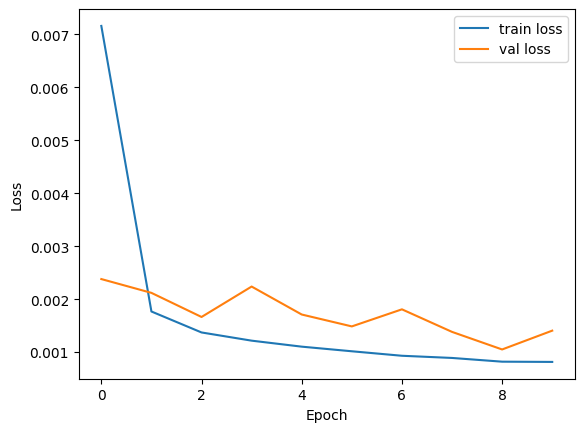

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Encoder-Decoder Model with Attention [20 points]:
Develop a similar model but with attention mechanism for better performance.

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(encoder_hidden_dim + decoder_hidden_dim, decoder_hidden_dim)
        self.v = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch size, decoder hidden dim]
        # encoder_outputs: [batch size, src len, encoder hidden dim]

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        # Repeat decoder hidden state src_len times
        hidden = hidden.squeeze(0).unsqueeze(1).repeat(1, src_len, 1)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class NewEncoder(nn.Module):
    def __init__(self, hidden_size, device, mobilenet_pretrained=True):
        super(NewEncoder, self).__init__()
        # Load the pretrained MobileNetV2 model and remove the classification layer
        self.mobilenet = models.mobilenet_v2(pretrained=mobilenet_pretrained)
        self.mobilenet = nn.Sequential(*(list(self.mobilenet.children())[:-1]))

        # Adaptive pooling layer and linear layer for feature transformation
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_size, batch_first=True, device=device)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a sequence length dimension
        # x is of shape (batch_size, seq_length, C, H, W)
        batch_size, seq_length, C, H, W = x.size()
        # Process through MobileNetV2
        x = x.view(batch_size * seq_length, C, H, W)
        x = self.mobilenet(x)

        # Apply adaptive pooling and linear transformation
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = x.view(batch_size, seq_length, -1)
        x.to(device)
        # Pass through LSTM
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell


class DecoderAttention(nn.Module):
    def __init__(self, hidden_size, sentence_embedding_size, output_size, embedding_model):
        super(DecoderAttention, self).__init__()
        # Embedding will be done outside the decoder before passing the sentence to the lstm
        # self.ft = embedding_model
        self.lstm = nn.LSTM(sentence_embedding_size, hidden_size, num_layers=1, batch_first=True)
        self.out = nn.Linear(hidden_size, sentence_embedding_size)  # output size =? max_sentence_length
        self.attention = Attention(hidden_size, hidden_size)
        self.input_transform = nn.Linear(306, 50)



    def forward(self, word, hidden, cell, encoder_outputs):

        # Calculate attention weights
        attention_weights = self.attention(hidden, encoder_outputs)

        # Apply attention weights to encoder outputs
        weighted = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)

        # print(weighted.shape)
        # print(word.shape)

        lstm_input = torch.cat((word, weighted), dim=2)
        lstm_input = self.input_transform(lstm_input)
        # print(lstm_input.shape)

        # Forward pass through LSTM
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.out(output.squeeze(1))
        return prediction, hidden, cell

class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.max_sentence_length = max_sentence_length

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = target.shape[0]
        max_len = self.max_sentence_length  # Maximum sentence length
        embedding_size = 50  # Size of word embedding

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, embedding_size).to(device)

        # start of the actual forward pass
        encoder_output, hidden, cell = self.encoder(source)

        # First input to the decoder is the <sos> token
        input = target[:, 0]
        input = input.unsqueeze(1)  # Reshape from [batch_size, features] to [batch_size, seq_length, features]
        # output, hidden, cell = self.decoder(input, hidden, cell)
        # print(input.shape)
        for t in range(1, max_len + 1):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_output)
            outputs[:, t-1] = output
            # if t == 1: just for checking
            #   print(output)
            # Decide whether to do teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            if (not t == max_len):
              input = target[:, t].unsqueeze(1)
              if (teacher_force):
                input = target[:, t].unsqueeze(1)
              else:
                input = output.unsqueeze(1)

        return outputs

initilize the model

In [ ]:
# Hyperparameters
hidden_size = 256  # Size of the hidden layers in LSTMs
embed_size = 50   # Size of the word embeddings from FastText
vocab_size = len(vocab)  # Size of your vocabulary
learning_rate = 1e-3 # I tried multiple learning rates and this is the best.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
newEncoder = NewEncoder(hidden_size=hidden_size, device=device)
decoderAttention = DecoderAttention(hidden_size = hidden_size, sentence_embedding_size = embed_size, output_size = max_sentence_length, embedding_model = ft)
seq2seqAttention = Seq2SeqAttention(encoder = newEncoder, decoder = decoderAttention)

seq2seqAttention = seq2seqAttention.to(device)


criterion = nn.L1Loss()
optimizer = optim.Adam(seq2seqAttention.parameters(), lr=learning_rate)


epochs = 10
print(device)

cuda


Training the model

In [ ]:
%%time
# Training step
train_losses = []
val_losses = []

for i in range(epochs):
  # Train step
  seq2seqAttention.train()
  batch_loss = 0
  epoch_loss = 0
  for batch_x, batch_y in train_loader:
    # move batche to device
    frames = batch_x.to(device)
    labels = batch_y.to(device)
    sentence_embeddings = get_sentence_embeddings(labels)
    sentence_embeddings = sentence_embeddings.to(device)
    # Forward pass
    output = seq2seqAttention(frames, sentence_embeddings)

    # find loss
    loss = criterion(output, sentence_embeddings)

    # backward propgation, update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_loss += loss.item() * batch_size
  train_epoch_loss = batch_loss / len(train_loader.dataset)
  train_losses.append(train_epoch_loss) # this is just for tracking

  # validation step
  seq2seq.eval()
  correct_labels = 0

  with torch.no_grad():
    batch_loss = 0
    epoch_loss = 0
    for batch_x, batch_y in val_loader:
      # move batche to device
      frames = batch_x.to(device)
      labels = batch_y.to(device)
      sentence_embeddings = get_sentence_embeddings(labels)
      sentence_embeddings = sentence_embeddings.to(device)
      # Forward pass
      output = seq2seqAttention(frames, sentence_embeddings)

      # find loss
      loss = criterion(output, sentence_embeddings)

      batch_loss += loss.item() * batch_size
    val_epoch_loss = batch_loss / len(test_loader.dataset)
    val_losses.append(val_epoch_loss) # this is just for tracking

  print(f'Epoch: {i}, train_loss={train_epoch_loss}, val_loss={val_epoch_loss}.)')

Epoch: 0, train_loss=0.007908002663297362, val_loss=0.002771072015589611.)
Epoch: 1, train_loss=0.0017383459881113751, val_loss=0.002432391791124687.)
Epoch: 2, train_loss=0.0015274416979586302, val_loss=0.0018280997487829264.)
Epoch: 3, train_loss=0.0012196671555426116, val_loss=0.0020872301118674153.)
Epoch: 4, train_loss=0.0011387423893459898, val_loss=0.0021166988084036294.)
Epoch: 5, train_loss=0.001017413781070733, val_loss=0.002126092777700361.)
Epoch: 6, train_loss=0.0009216634968519367, val_loss=0.001178804806003234.)
Epoch: 7, train_loss=0.0009110493213548727, val_loss=0.0011743161121778416.)
Epoch: 8, train_loss=0.0008332444695690001, val_loss=0.0012880855945475173.)
Epoch: 9, train_loss=0.0008489627032125436, val_loss=0.001968758042802978.)
CPU times: user 1h 39min 5s, sys: 22.1 s, total: 1h 39min 27s
Wall time: 37min 44s


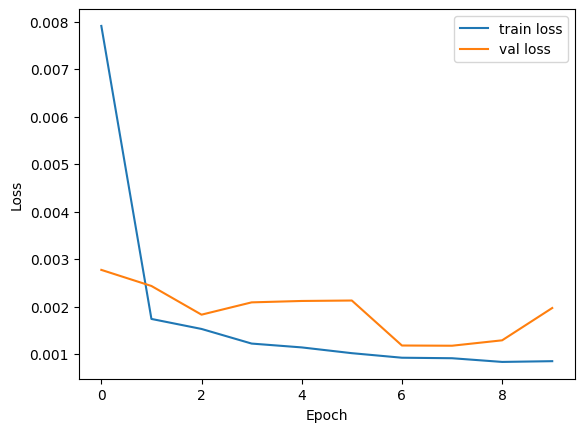

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Report Results Using WER Metric [10 points]

In [ ]:
def wer(reference, hypothesis):
    ref_words = reference.split()
    hyp_words = hypothesis.split()

    M, N = len(ref_words), len(hyp_words)
    distance_matrix = [[0] * (N + 1) for _ in range(M + 1)]

    for i in range(1, M + 1):
        distance_matrix[i][0] = i
    for j in range(1, N + 1):
        distance_matrix[0][j] = j

    for i in range(1, M + 1):
        for j in range(1, N + 1):
            if ref_words[i - 1] == hyp_words[j - 1]:
                distance_matrix[i][j] = distance_matrix[i - 1][j - 1]
            else:
                substitution = distance_matrix[i - 1][j - 1] + 1
                insertion = distance_matrix[i][j - 1] + 1
                deletion = distance_matrix[i - 1][j] + 1
                distance_matrix[i][j] = min(substitution, insertion, deletion)
    return distance_matrix[M][N] / M

def nearest_embedding_to_word(embedding, ft_model, vocab):
    # Find the nearest word in the vocabulary (I got the vocb in part 2) for a given embedding
    min_dist = float('inf')
    nearest_word = None
    for word in vocab:
        word_embedding = torch.tensor(ft_model.get_word_vector(word)).to(device)
        dist = torch.norm(embedding - torch.tensor(word_embedding))
        if dist < min_dist:
            min_dist = dist
            nearest_word = word
    return nearest_word
# test
print()

### Average WER for sequence to sequence without Attention

In [ ]:
seq2seq.eval()
total_wer = 0
total_sentences = 0
## This is just for printing purposes
used = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        frames = batch_x.to(device)
        labels = batch_y.to(device)
        groundTruthSentences = get_ground_truth(labels)
        sentence_embeddings = get_sentence_embeddings(labels).to(device)

        # Forward pass to get output from seq2seq model
        output = seq2seq.forward(frames, sentence_embeddings, teacher_forcing_ratio=0)

        # Convert output embeddings to sentences
        predictions = []
        for i in range(output.shape[0]):
            ground_truth_length = len(groundTruthSentences[i].split())
            predicted_sentence = ' '.join([nearest_embedding_to_word(output[i, t, :], ft, vocab)
                                          for t in range(ground_truth_length)])
            predictions.append(predicted_sentence)

        # Calculate WER for each pair and accumulate
        for pred, truth in zip(predictions, groundTruthSentences):
            if (random.random() > 0.98 and truth not in used): ## Print some sentences randomly, if the truth sentence is printed before, then I am not priniting it.
                used.append(truth)
                print(f"Generated: {pred}")
                print(f"Actual: {truth}")
            total_wer += wer(truth, pred)
            total_sentences += 1

avg_wer = total_wer / total_sentences

print(f"Average Word Error Rate for sequence to sequence without attentions is : {avg_wer}")


<ipython-input-19-0149237e33a1>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.norm(embedding - torch.tensor(word_embedding))


Generated: اسم الله
Actual: اسم الله
Generated: الحمد الله
Actual: الحمد الله
Generated: جميع الصم العرب السامع
Actual: جميع الصم العرب  السامع
Generated: السلام عليكم رحمة الله بركة
Actual: السلام عليكم رحمة الله بركة
Generated: اليوم اقدم انتم برنامج اخر
Actual: اليوم اقدم انتم برنامج اخر
Generated: موضوع دراسة لغة الاشارة العربية
Actual: موضوع دراسة لغة الاشارة العربية
Generated: كلمات اليوم متفرقة في الدين
Actual: كلمات اليوم متفرقة في الدين
Generated: ايضا كلمات عادية
Actual: ايضا كلمات عادية
Generated: لا شرك الله
Actual: لا شرك الله
Generated: الله اكبر
Actual: الله اكبر
Average Word Error Rate for sequence to sequence without attentions is : 0.0


### Average WER for sequence to sequence with Attention

In [ ]:
seq2seqAttention.eval()
total_wer = 0
total_sentences = 0
used = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        frames = batch_x.to(device)
        labels = batch_y.to(device)
        groundTruthSentences = get_ground_truth(labels)
        sentence_embeddings = get_sentence_embeddings(labels).to(device)

        # Forward pass to get output from seq2seqAttention model
        output = seq2seqAttention.forward(frames, sentence_embeddings, teacher_forcing_ratio=0)

        # Convert output embeddings to sentences
        predictions = []
        for i in range(output.shape[0]):
            ground_truth_length = len(groundTruthSentences[i].split())
            predicted_sentence = ' '.join([nearest_embedding_to_word(output[i, t, :], ft, vocab)
                                          for t in range(ground_truth_length)])
            predictions.append(predicted_sentence)

        # Calculate WER for each pair and accumulate
        for pred, truth in zip(predictions, groundTruthSentences):
            if (random.random() > 0.98 and truth not in used): ## Print some sentences randomly, if the truth sentence is printed before, then I am not priniting it.
                used.append(truth)
                print(f"Generated: {pred}")
                print(f"Actual: {truth}")
            total_wer += wer(truth, pred)
            total_sentences += 1

avg_wer = total_wer / total_sentences

print(f"Average Word Error Rate for sequence to sequence with attention is : {avg_wer}")


<ipython-input-19-0149237e33a1>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.norm(embedding - torch.tensor(word_embedding))


Generated: اسم الله
Actual: اسم الله
Generated: الحمد الله
Actual: الحمد الله
Generated: جميع الصم العرب السامع
Actual: جميع الصم العرب  السامع
Generated: السلام عليكم رحمة الله بركة
Actual: السلام عليكم رحمة الله بركة
Generated: اليوم اقدم انتم برنامج اخر
Actual: اليوم اقدم انتم برنامج اخر
Generated: موضوع دراسة لغة الاشارة العربية
Actual: موضوع دراسة لغة الاشارة العربية
Generated: كلمات اليوم متفرقة في الدين
Actual: كلمات اليوم متفرقة في الدين
Generated: ايضا كلمات عادية
Actual: ايضا كلمات عادية
Generated: لا شرك الله
Actual: لا شرك الله
Generated: الله اكبر
Actual: الله اكبر
Average Word Error Rate for sequence to sequence with attention is : 0.02946969696969683


### investigate the genration of a sentence using my models
This is just to see why WER is not 0.0

In [ ]:
# seq2seq.eval()

# for batch_x, batch_y in test_loader:
#     frames = batch_x.to(device)
#     labels = batch_y.to(device)
#     groundTruthSentences = get_ground_truth(labels)
#     sentence_embeddings = get_sentence_embeddings(labels).to(device)

#     # Forward pass to get output from seq2seqAttention model
#     output = seq2seq.forward(frames, sentence_embeddings, teacher_forcing_ratio=0)

#     predictions = []
#     for i in range(output.shape[0]):
#         ground_truth_length = len(groundTruthSentences[i].split())
#         predicted_sentence = ' '.join([nearest_embedding_to_word(output[i, t, :], ft, vocab)
#                                       for t in range(ground_truth_length)])
#         predictions.append(predicted_sentence)
#     # Print sentence from the first element in the batch
#     print("Generated: ", predictions[0])
#     print("Actual: ", groundTruthSentences[0])
#     break


seq2seqAttention.eval()

for batch_x, batch_y in test_loader:
    frames = batch_x.to(device)
    labels = batch_y.to(device)
    groundTruthSentences = get_ground_truth(labels)
    sentence_embeddings = get_sentence_embeddings(labels).to(device)

    # Forward pass to get output from seq2seqAttention model
    output = seq2seqAttention.forward(frames, sentence_embeddings, teacher_forcing_ratio=0)
    predictions = []
    for i in range(output.shape[0]):
        ground_truth_length = len(groundTruthSentences[i].split())
        predicted_sentence = ' '.join([nearest_embedding_to_word(output[i, t, :], ft, vocab)
                                      for t in range(ground_truth_length)])
        predictions.append(predicted_sentence)
    # Print sentence from the first element in the batch
    flag = False
    for pred, truth in zip(predictions, groundTruthSentences):
        wer_s = wer(truth, pred)
        if (wer_s > 0): ## Print some sentences randomly, if the truth sentence is printed before, then I am not priniting it.
            print(f"Generated: {pred}")
            print(f"Actual: {truth}")
            flag = True
            break
    if (flag):
        break



<ipython-input-19-0149237e33a1>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.norm(embedding - torch.tensor(word_embedding))


Generated: الحمد عليكم
Actual: الحمد الله
